In [1]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import time

%matplotlib inline

In [2]:
def plot_on_subplot(ax, traj, title="", xlabel='x (m)', ylabel='y (m)'):
    ax.set_title(title)
    ax.plot(traj[:, 0], traj[:, 1])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

def plot_2d_parallels(traj, label_t1, traj_gt, label_t2,
                      title="", xlabel='x (m)', ylabel='y (m)'):
    mpl.rcParams['legend.fontsize'] = 10
    
    fig = plt.figure(figsize=(9,3))
    plt.suptitle(title)
    
    ax = fig.add_subplot(121)
    ax.set_title(label_t1)
    ax.plot(traj[:, 0], traj[:, 1], label=label_t1)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax = fig.add_subplot(122)
    ax.set_title(label_t2)
    ax.plot(traj_gt[:, 0], traj_gt[:, 1], label=label_t2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    plt.show()
    
def plot_2d(traj, label_t1, traj_gt=None, label_t2="",
            title="", xlabel='x (m)', ylabel='y (m)'):
    mpl.rcParams['legend.fontsize'] = 10
    
    fig = plt.figure()
    plt.title(title)
    plt.plot(traj[:, 0], traj[:, 1], label=label_t1)
    if traj_gt is not None:
        plt.plot(traj_gt[:, 0], traj_gt[:, 1], label=label_t2)
        plt.legend()
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def plot_3d(traj, traj_gt=None):
    mpl.rcParams['legend.fontsize'] = 10

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], label='SDSLAM')
    if traj_gt is not None:
        ax.plot(traj_gt[:, 0], traj_gt[:, 1], traj_gt[:, 2], label='GT')
        ax.legend()

    plt.show()

def plot_2d_realtime(traj, speed=30):
    mpl.rcParams['legend.fontsize'] = 10
    
    border = 1.2  # 20%
    lims = (min(traj[:, 0])*1.2 , max(traj[:, 0])*1.2 ,
            min(traj[:, 1])*1.2 , max(traj[:, 1])*1.2 )
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.ion()
    fig.show()
    fig.canvas.draw()
    
    
    for i in np.arange(0, traj.shape[0], speed):
        ax.clear()
        ax.set_xlabel('x (m)')
        ax.set_ylabel('y (m)')
        ax.set_xlim(left=lims[0], right=lims[1])
        ax.set_ylim(top=lims[3], bottom=lims[2])
        
        ax.plot(traj[:i, 0], traj[:i, 1])
        fig.canvas.draw()

In [3]:
def load_gt_file(path):
    return np.genfromtxt(path, delimiter=',', 
                             names=['timestamp',
                                    'p_x', 'p_y', 'p_z', 
                                    'q_x', 'q_y', 'q_z', 'q_w',
                                    'v_x', 'v_y', 'v_z',
                                    'w_x', 'w_y', 'w_z',
                                    'a_x', 'a_y', 'a_z'])
def load_pose_file(path):
    return np.genfromtxt(path, delimiter=',', 
                         names=['timestamp',
                                'p_x', 'p_y', 'p_z', 
                                'q_x', 'q_y', 'q_z', 'q_w'])

def load_predicted_pose_file(path, include_acceleration=False):
    if include_acceleration:
        return np.genfromtxt(path, delimiter=',', 
                             names=['p_x', 'p_y', 'p_z', 
                                    'q_x', 'q_y', 'q_z', 'q_w',
                                    'v_x', 'v_y', 'v_z',
                                    'w_x', 'w_y', 'w_z',
                                    'a_x', 'a_y', 'a_z'])
    else:
        return np.genfromtxt(path, delimiter=',', 
                             names=['p_x', 'p_y', 'p_z', 
                                    'q_x', 'q_y', 'q_z', 'q_w',
                                    'v_x', 'v_y', 'v_z',
                                    'w_x', 'w_y', 'w_z'])
    

---

##### --- Load files ---

In [4]:
GT_FILE = './data/EuRoC_V1_02/gt.csv'

NO_MOTION_MODEL_FILE = './data/EuRoC_V1_02/pose_lastpose.csv'

FUSION_FILE = './data/EuRoC_V1_02/pose_fusion.csv'
FUSION_PREDICTED_FILE = './data/EuRoC_V1_02/ppose_fusion.csv'

MONOCULAR_FILE = './data/EuRoC_V1_02/pose_mono.csv'
MONOCULAR_PREDICTED_FILE = './data/EuRoC_V1_02/ppose_mono.csv'

In [5]:
gt = load_gt_file(GT_FILE)

no_motion_model_final = load_pose_file(NO_MOTION_MODEL_FILE)

mono_estimated = load_predicted_pose_file(MONOCULAR_PREDICTED_FILE)
mono_final = load_pose_file(MONOCULAR_FILE)

fusion_estimated = load_predicted_pose_file(FUSION_PREDICTED_FILE)
fusion_final = load_pose_file(FUSION_FILE)

---
# Analysis of trajectories

Graphical comparison between the estimated position (predicted by an EKF filter) vs. the final position generated by the Tracking module in Monocular SD-SLAM and Fusion SD-SLAM.

Motion model:
* Monocular: constant velocity
* Fusion: IMU data (angular velocity and linear acceleration

In [6]:
def traj_xy(data):
    return np.vstack((data['p_x'], data['p_y'])).T

def traj_z(data, timestamp=True):
    if timestamp:
        return np.vstack((data['timestamp'], data['p_z'])).T
    else:
        timestamp_aux = np.arange(data.shape[0])
        return np.vstack((timestamp_aux, data['p_z'])).T

In [7]:
# XY
gt_pose_xy               = traj_xy(gt)
no_motion_model_pose_xy  = traj_xy(no_motion_model_final)
mono_estimated_pose_xy   = traj_xy(mono_estimated)
mono_pose_xy             = traj_xy(mono_final)
fusion_estimated_pose_xy = traj_xy(fusion_estimated)
fusion_pose_xy           = traj_xy(fusion_final)

## GroundTruth Trajectory

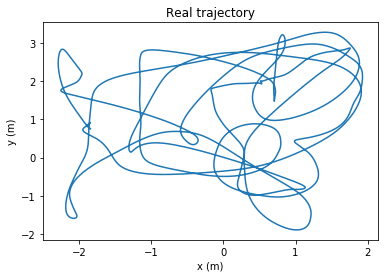

In [8]:
plot_2d(gt_pose_xy, "", title="Real trajectory")

---
## Estimated pose

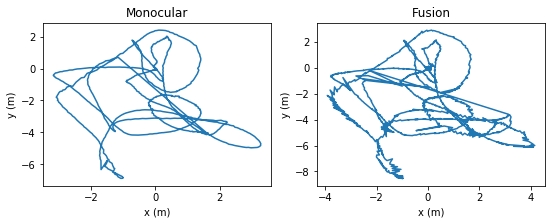

In [9]:
plot_2d_parallels(mono_estimated_pose_xy, "Monocular", fusion_estimated_pose_xy, "Fusion")

## Final pose


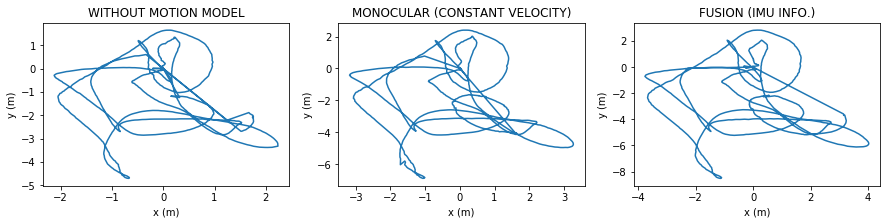

In [10]:
fig = plt.figure(figsize=(15,3))
plot_on_subplot(fig.add_subplot(131), no_motion_model_pose_xy, "WITHOUT MOTION MODEL")
plot_on_subplot(fig.add_subplot(132), mono_pose_xy, "MONOCULAR (CONSTANT VELOCITY)")
plot_on_subplot(fig.add_subplot(133), fusion_pose_xy, "FUSION (IMU INFO.)")

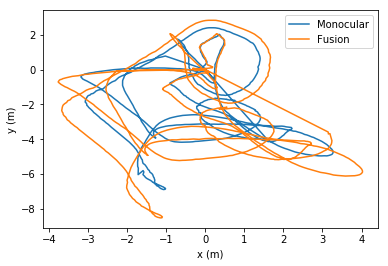

In [11]:
plot_2d(mono_pose_xy, "Monocular", fusion_pose_xy, "Fusion")

---
## Estimated vs Final

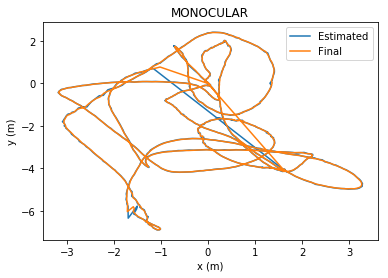

In [12]:
plot_2d(mono_estimated_pose_xy, "Estimated", mono_pose_xy, "Final", title="MONOCULAR")

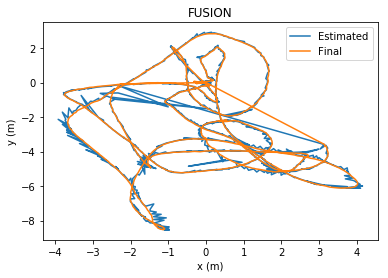

In [13]:
plot_2d(fusion_estimated_pose_xy, "Estimated", fusion_pose_xy, "Final", title="FUSION")

In [14]:
# Z
gt_pose_z               = traj_z(gt)
mono_estimated_pose_z   = traj_z(mono_estimated, timestamp=False)
mono_pose_z             = traj_z(mono_final, timestamp=False)
fusion_estimated_pose_z = traj_z(fusion_estimated, timestamp=False)
fusion_pose_z           = traj_z(fusion_final, timestamp=False)

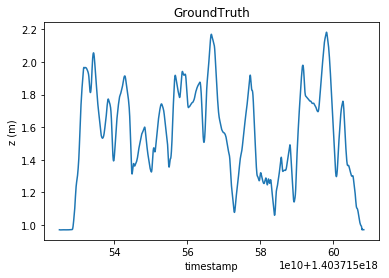

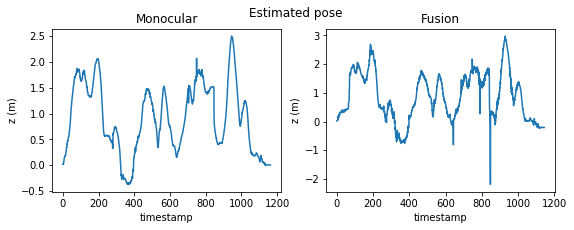

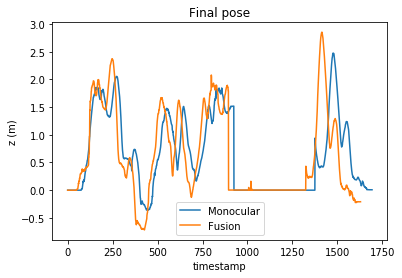

In [15]:
plot_2d(gt_pose_z, ' ', title='GroundTruth', 
        xlabel='timestamp', ylabel='z (m)')
plot_2d_parallels(mono_estimated_pose_z, 'Monocular', fusion_estimated_pose_z, 'Fusion',
                  title='Estimated pose', xlabel='timestamp', ylabel='z (m)')
plot_2d(mono_pose_z, 'Monocular', fusion_pose_z, 'Fusion',
                  title='Final pose', xlabel='timestamp', ylabel='z (m)')

---
## Velocity

In [16]:
def velocity(data):
    timestamp = np.arange(data.shape[0])
    v = np.sqrt(data['v_x']**2 + data['v_y']**2 + data['v_z']**2)
    return np.vstack((timestamp, v)).T

In [17]:
# |v|
gt_v               = velocity(gt)
mono_estimated_v   = velocity(mono_estimated)
fusion_estimated_v = velocity(fusion_estimated)

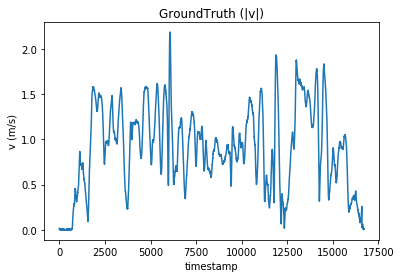

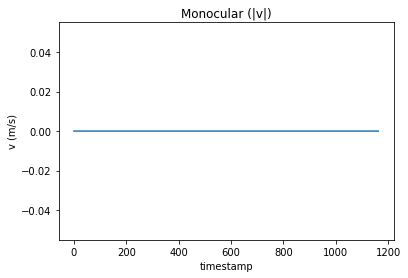

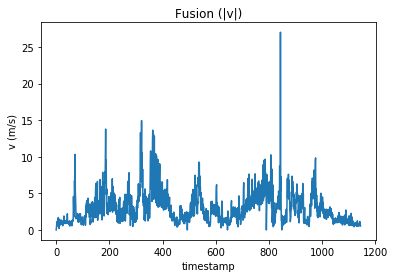

In [18]:
plot_2d(gt_v, ' ', title='GroundTruth (|v|)', xlabel='timestamp', ylabel='v (m/s)')
plot_2d(mono_estimated_v, ' ', title='Monocular (|v|)', xlabel='timestamp', ylabel='v (m/s)')
plot_2d(fusion_estimated_v, ' ', title='Fusion (|v|)', xlabel='timestamp', ylabel='v (m/s)')